In [1]:
# import networkx as nx
import numpy as np
import scipy.io as scio
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time

%matplotlib inline
plt.style.use('ggplot')
sns.set()

In [2]:
def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)

In [3]:
# 网络数据导入为numpy数组
dataFile_1 = './data/BA_2000_3.mat'
data_1 = scio.loadmat(dataFile_1)
network_scale_1 = data_1['A'].shape
network_physical = np.array(data_1['A'])
# network_physical = nx.Graph(data['A'])

dataFile_2 = './data/BA_2000_3_add_400_edges.mat'
data_2 = scio.loadmat(dataFile_2)
network_scale_2  = data_2['B'].shape
network_information = np.array(data_2['B'])
# network_information = nx.Graph(data['A'])

assert network_scale_1 == network_scale_2, "networks\' size don\'t match!"
assert check_symmetric(network_physical), "network_physical doesn\'t symmetry!"
assert check_symmetric(network_information), "network_information doesn\'t symmetry!"
if np.sum(np.sum(network_physical, axis=0)==0):
    print("The network is integral")

In [4]:
# 参数设置

# 公共参数
Monte_Carlo_loop = 20    # 蒙特卡洛模拟次数
time_steps = 50    # 总时间步数
N = network_scale_1[0]    # 网络节点数

# p = random.randint(0, N-1)    # 初始始随机选出一个感染节点，四舍五入

# SIS参数
bata = 0.2    # 感染概率
mu = 0.1    # 恢复概率

Nodes_SIS = np.zeros([Monte_Carlo_loop, time_steps, N])    # N行代表时间步数，T列代表节点数，记录每步所有节点的感染状态
# Nodes_SIS[0, p] = 1    # 第一步标出初始感染节点的位置

infective_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步感染节点数,用于最终统计
infective_count_average = np.zeros([1, time_steps])

# UAU参数
lamda = 0.4    # 传播率
delta = 0.15    # 遗忘率

Nodes_UAU = np.zeros([Monte_Carlo_loop, time_steps, N])    # 存储网络中每个节点的知情状态快照
# Nodes_UAU[0, p] = 1    # 随机初始化一个节点使其处于感染状态，当前可感染状态节点的快照

awareness_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步知晓节点数量,用于最终统计
awareness_count_average = np.zeros([1, time_steps])

# 节点活跃度
# inactiverate = 0.4
# activerate = 0.6

inactiverate = 0
activerate = 1

Node_Active = np.ones([Monte_Carlo_loop, time_steps, N])    # 存储网络中每个节点的活跃状态快照
inactive_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步知晓节点数量,用于最终统计
inactive_count_average = np.zeros([1, time_steps])

# 其他参数
# aplha = 0    # 信息上传率
aplha = 0.6    # 信息上传率
sigma_S = 0.7    # S节点在知道信息后的防御系数/感染率衰减, 相当于减少与周围人的接触

In [5]:
time_start = time.time()

for loop in range(Monte_Carlo_loop):

    p = random.randint(0, N-1)    # 初始始随机选出一个感染节点，四舍五入

    Nodes_SIS[loop, 0, p] = 1    # 第一步标出初始感染节点的位置
    Nodes_UAU[loop, 0, p] = 1    # 随机初始化一个节点使其处于感染状态，当前可感染状态节点的快照

    # 初始节点依概率变得不活跃
    p0 = np.random.rand(1)
#     if p0 <= inactiverate:
    if p0 < inactiverate:
        Node_Active[loop, 0, p] = 0    # 初始节点不活跃

    for t in range(time_steps-1):

        # UAU演化

        awareness_nodes = np.where((Nodes_UAU[loop, t, :] == 1))[0]    # 找到当前有传播力的节点的位置

        # UAU传播过程
        for a in awareness_nodes:

            neighbor_total = np.where(network_information[a, :] == 1)[0]    # 找到第i个有传染力节点的邻居        
            neighbor_listener = np.setdiff1d(neighbor_total, awareness_nodes)    # 从neighbor_total去除awareness_nodes的节点，排除知情邻居

            # 让节点依次感染邻居(这种方式和SIS的的感染方式效果相同？)
            for j in neighbor_listener:
                p1 = np.random.rand(1)
                if p1 <= lamda:
                    Nodes_UAU[loop, t+1, j] = 1    # 这个节点已知

                    # 成功感染的节点下一时刻依概率变得不活跃
                    p3 = np.random.rand(1)
#                     if p3 <= inactiverate:
                    if p3 < inactiverate:
                        Node_Active[loop, t+1, j] = 0    # 这个节点不活跃

            # UAU遗忘过程
            p2 = np.random.rand(1)
            if p2 <= delta:
                Nodes_UAU[loop, t+1, a] = 0    # 这个节点遗忘

                # 节点依概率变得活跃
                p4 = np.random.rand(1)
#                 if p4 <= inactiverate:
                if p4 < activerate:
                    Node_Active[loop, t+1, a] = 1    # 这个节点重新活跃
                else:
                    Node_Active[loop, t+1, a] = 0
            else:
                Nodes_UAU[loop, t+1, a] = 1
                if Node_Active[loop, t, a] == 0:
                    Node_Active[loop, t+1, a] = 0
                


        # SIS演化
        for i in range(N):

            # 0代表易感(S)，如果节点i健康且活跃，就查找其I状态的邻居（活跃节点处理方式不变）
            if ((Nodes_SIS[loop, t, i] == 0) and (Node_Active[loop, t, i] == 1)):

                neighbor_total = np.where((network_physical[i, :] == 1))[0]    # 查找其邻居
                infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]    # 查找感染节点
                neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)    # 取交集，真正可以感染它的邻居
                Num_neighbor_infective = len(neighbor_infective)    # 统计

                infect_rate_current = bata    # 当前临时感染率
                rate_temp = 1    # 用于计算感染率

                # SIS感染率改变规则
                if Nodes_UAU[loop, t, i] == 0:
                    rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective                 

                elif Nodes_UAU[loop, t, i] == 1:
                    infect_rate_current = infect_rate_current * sigma_S    # 当前临时感染率
                    rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective


                # SIS感染过程
                v1 = 1 - rate_temp    # 这是最终计算的感染率？
                x1 = np.random.rand(1)
                if x1 <= v1:
                    Nodes_SIS[loop, t+1, i] = 1

                    # 感染节点信息上传(知晓)
                    x2 = np.random.rand(1)
                    if  x2 <= aplha:
                        Nodes_UAU[loop, t+1, i] = 1

                        # 成功感染的节点下一时刻依概率变得不活跃
                        x4 = np.random.rand(1)
#                         if x4 <= inactiverate:
                        if x4 < inactiverate:
                            Node_Active[loop, t+1, i] = 0    # 这个节点不活跃

            # 0代表易感(S)，如果节点i健康且不活跃，就查找其I状态的邻居
            elif ((Nodes_SIS[loop, t, i] == 0) and (Node_Active[loop, t, i] == 0)):

                neighbor_total = np.where((network_physical[i, :] == 1))[0]    # 查找其邻居

                infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]    # 感染节点
                active_nodes = np.where((Node_Active[loop, t, :] == 1))[0]    # 活跃节点

                neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)    # 取交集，真正可以感染它的邻居
                neighbor_infective_active = np.intersect1d(neighbor_infective, active_nodes)    # 取交集，真正可以感染它的活跃邻居

                Num_neighbor_infective_active = len(neighbor_infective_active)    # 统计

                infect_rate_current = bata    # 当前临时感染率
                rate_temp = 1    # 用于计算感染率

                # SIS感染率改变规则
                if Nodes_UAU[loop, t, i] == 0:
                    rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective_active                 

                elif Nodes_UAU[loop, t, i] == 1:
                    infect_rate_current = infect_rate_current * sigma_S    # 当前临时感染率
                    rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective_active


                # SIS感染过程
                v1 = 1 - rate_temp    # 这是最终计算的感染率？
                x1 = np.random.rand(1)
                if x1 <= v1:
                    Nodes_SIS[loop, t+1, i] = 1

                    # 感染节点信息上传(知晓)
                    x2 = np.random.rand(1)
                    if  x2 <= aplha:
                        Nodes_UAU[loop, t+1, i] = 1
                    
                        # 成功感染的节点下一时刻依概率变得不活跃
                        x4 = np.random.rand(1)
#                         if x4 <= inactiverate:
                        if x4 < inactiverate:
                            Node_Active[loop, t+1, i] = 0    # 这个节点不活跃

            # SIS康复过程
            elif Nodes_SIS[loop, t, i] == 1:

                recover_rate_current = mu
                x3 = np.random.rand(1) 
                if x3 <= recover_rate_current:
                    Nodes_SIS[loop, t+1, i] = 0
                else:
                    Nodes_SIS[loop, t+1, i] = 1

            else:
                print("There is an else condition in SIS!")

    print("loop {} - time has passed: {} ".format(loop, time.time()-time_start))

loop 0 - time has passed: 6.299534559249878 
loop 1 - time has passed: 12.663645505905151 
loop 2 - time has passed: 19.136121034622192 
loop 3 - time has passed: 25.46219515800476 
loop 4 - time has passed: 31.777267694473267 
loop 5 - time has passed: 38.18018126487732 
loop 6 - time has passed: 44.62590456008911 
loop 7 - time has passed: 50.992913484573364 
loop 8 - time has passed: 57.27610921859741 
loop 9 - time has passed: 63.74975514411926 
loop 10 - time has passed: 70.30725836753845 
loop 11 - time has passed: 76.621328830719 
loop 12 - time has passed: 83.14193272590637 
loop 13 - time has passed: 89.63257193565369 
loop 14 - time has passed: 96.06636095046997 
loop 15 - time has passed: 102.50609850883484 
loop 16 - time has passed: 109.20223188400269 
loop 17 - time has passed: 115.78860521316528 
loop 18 - time has passed: 122.36697936058044 
loop 19 - time has passed: 128.9414360523224 


In [6]:
# datasave = './results/result.mat'
# scio.savemat(datasave, {'NodeSIS':Nodes_SIS, 'NodeUAU':Nodes_UAU, 'Node_Active':Node_Active})

# print("Nodes_SIS: ", Nodes_SIS)
# print("Nodes_UAU: ", Nodes_UAU)

In [7]:
# 处理数据
for loop_ in range(Monte_Carlo_loop):
    infective_count[loop_,:] = np.sum(Nodes_SIS[loop_,:,:], axis=1)
    awareness_count[loop_,:] = np.sum(Nodes_UAU[loop_,:,:], axis=1)
    inactive_count[loop_,:] = np.sum((1-Node_Active[loop_,:,:]), axis=1)
    
infective_count_average = np.mean(infective_count, axis=0)
awareness_count_average = np.mean(awareness_count, axis=0)
inactive_count_average = np.mean(inactive_count, axis=0)

assert infective_count_average.shape == (time_steps,), "infective_count_average\'s size don\'t match!"
assert awareness_count_average.shape == (time_steps,), "awareness_count_average\'s size don\'t match!"
assert inactive_count_average.shape == (time_steps,), "inactive_count_average\'s size don\'t match!"

# print("infective_count_average: ", infective_count_average)
# print("awareness_count_average: ", awareness_count_average)

## 规模参照
# Nodes_SIS = np.zeros([Monte_Carlo_loop, time_steps, N])
# infective_count = np.zeros([Monte_Carlo_loop, time_steps])
# infective_count_average = np.zeros([1, time_steps])

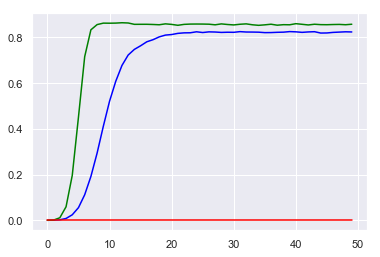

In [8]:
# 不引入活跃
plt.plot(infective_count_average/N, color='blue', label='SIS')
plt.plot(awareness_count_average/N, color='green', label='UAU')
plt.plot(inactive_count_average/N, color='red', label='inactive')

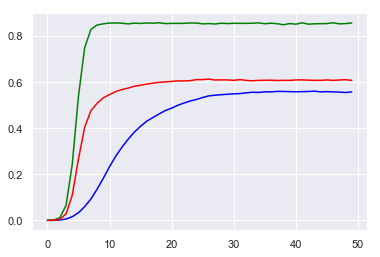

In [8]:
# 引入活跃
plt.plot(infective_count_average/N, color='blue', label='SIS')
plt.plot(awareness_count_average/N, color='green', label='UAU')
plt.plot(inactive_count_average/N, color='red', label='inactive')

In [ ]:
# 不活跃节点比例稳定以后始终比知情节点固定低一点

# 一种原因：接触层的信息上传会使得知情节点比正常演化多一点，并且来不及在当前时间更新为不活跃状态(已经证实)

# 已修复

In [ ]:
import time

print ("time.time(): %f " %time.time())

time_start=time.time()
time.sleep(1)
time_end=time.time()
print('totally cost',time_end-time_start)

In [ ]:
a = np.array([[1,2],[3,4],[5,6]])
datasave = './results/result.mat'
scio.savemat(datasave, {'A':a})
data_1 = scio.loadmat(datasave)